<a href="https://colab.research.google.com/github/Anastasia-st2/test/blob/main/Gorina_Anastasia/%D0%9D%D0%BE%D0%B2%D1%8B%D0%B9_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82_15(3600_%D0%BE%D0%B4%D0%BD%D0%BE_%D1%81%D0%BB%D0%BE%D0%B2%D0%BE)_%D0%A0%D0%B5%D1%87%D1%8C_%D0%B2_%D1%82%D0%B5%D0%BA%D1%81%D1%82__DeepSpeech_031023_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ссылка на датасет
https://drive.google.com/file/d/1yhvN7aJekNX1f6Zpv558-_aB5WG61u_b/view?usp=sharing

> за основу взять датасет common_voice_15 из которого взяты только фразы с одним словом

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tarfile
import pandas as pd
import os
import librosa
import scipy
import numpy as np
from numpy.lib.stride_tricks import as_strided
from IPython.display import Audio

import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, BatchNormalization, ZeroPadding1D, Conv1D, TimeDistributed, Dense, Bidirectional, GRU, Lambda
from tensorflow.compat.v1.keras.layers import CuDNNGRU
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

#Prepare char map

In [3]:
# Alphabet + space + unknown
char_map_str = """
<SPACE> 0
а 1
б 2
в 3
г 4
д 5
е 6
ё 7
ж 8
з 9
и 10
й 11
к 12
л 13
м 14
н 15
о 16
п 17
р 18
с 19
т 20
у 21
ф 22
х 23
ц 24
ч 25
ш 26
щ 27
ъ 28
ы 29
ь 30
э 31
ю 32
я 33
' 34
"""

char_map = {}
index_map = {}

for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)] = ch

index_map[0] = ' '

def text_to_int_sequence(text):
    """ Use a character map and convert text to an integer sequence """
    int_sequence = []
    for c in text.lower():
        if c == ' ':
            ch = char_map['<SPACE>']
        else:
            ch = char_map[c]
        int_sequence.append(ch)
    return int_sequence

In [4]:
#How it works:
print("char_map:", char_map)
print("index map:", index_map)
privet = "Привет"
print(privet+": ", text_to_int_sequence(privet))

char_map: {'<SPACE>': 0, 'а': 1, 'б': 2, 'в': 3, 'г': 4, 'д': 5, 'е': 6, 'ё': 7, 'ж': 8, 'з': 9, 'и': 10, 'й': 11, 'к': 12, 'л': 13, 'м': 14, 'н': 15, 'о': 16, 'п': 17, 'р': 18, 'с': 19, 'т': 20, 'у': 21, 'ф': 22, 'х': 23, 'ц': 24, 'ч': 25, 'ш': 26, 'щ': 27, 'ъ': 28, 'ы': 29, 'ь': 30, 'э': 31, 'ю': 32, 'я': 33, "'": 34}
index map: {0: ' ', 1: 'а', 2: 'б', 3: 'в', 4: 'г', 5: 'д', 6: 'е', 7: 'ё', 8: 'ж', 9: 'з', 10: 'и', 11: 'й', 12: 'к', 13: 'л', 14: 'м', 15: 'н', 16: 'о', 17: 'п', 18: 'р', 19: 'с', 20: 'т', 21: 'у', 22: 'ф', 23: 'х', 24: 'ц', 25: 'ч', 26: 'ш', 27: 'щ', 28: 'ъ', 29: 'ы', 30: 'ь', 31: 'э', 32: 'ю', 33: 'я', 34: "'"}
Привет:  [17, 18, 10, 3, 6, 20]


#Import Data

In [5]:
#Preparing DataFrame
def combine_all_wavs_and_trans_from_csvs(csvslist, sortagrad=True, createwordlist=False, delBigTranscripts=True):
    '''Assume that data is in csv already exists with data in form
        path, size, transcript
        this is best approach for loading in moz deepspeech processed files.
    '''

    df_all = pd.DataFrame()

    #Reading all tsv (same as csv, but TAB separated)
    for csv in csvslist.split(','):
        if os.path.isfile(csv):
            df_new = pd.read_csv(csv, sep='\t', encoding='utf-8')
            df_all = df_all.append(df_new)

    #Removing word "Firefox"
    df_all = df_all[df_all['sentence'] != "Firefox"]

    #Removing long words
    if delBigTranscripts:
        df_final = df_all[df_all['sentence'].map(len) <= 40]
    else:
        df_final = df_all

    # can output the word list here if required
    if createwordlist:
        df_final['sentence'].to_csv("./DeepSpeech/df_all_word_list.csv", sep=',', header=False, index=False)  # reorder + out

    return df_final

def get_number_of_char_classes():
    ## would be better to check with dataset (once cleaned)
    num_classes = len(char_map)+1 ##need +1 for ctc null char +1 pad
    return num_classes

#Spectrogram processor

In [6]:
spectrogram_cache = {}

##############################################################################

def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram
    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).
    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x
    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs


def spectrogram_from_file(filename, step=10, window=20, max_freq=None,
                          eps=1e-14):
    """ Calculate the log of linear spectrogram from FFT energy
    Params:
        filename (str): Path to the audio file
        step (int): Step size in milliseconds between windows
        window (int): FFT window size in milliseconds
        max_freq (int): Only FFT bins corresponding to frequencies between
            [0, max_freq] are returned
        eps (float): Small value to ensure numerical stability (for ln(x))
    """

    if filename in spectrogram_cache:
      return spectrogram_cache[filename]


    audio, sample_rate = librosa.load(filename, sr=16000)
    max_freq = sample_rate / 2
    if step > window:
      raise ValueError("step size must not be greater than window size")
    hop_length = int(0.001 * step * sample_rate)
    fft_length = int(0.001 * window * sample_rate)
    pxx, freqs = spectrogram(
            audio, fft_length=fft_length, sample_rate=sample_rate,
            hop_length=hop_length)
    ind = np.where(freqs <= max_freq)[0][-1] + 1
    spg = np.transpose(np.log(pxx[:ind, :] + eps))
    spectrogram_cache[filename] = spg
    return spg

#Batch generator

In [7]:
class BatchGenerator(object):
    def __init__(self, dataframe, batch_size):
        self.df = dataframe.copy()
        self.wavpath  = [soundfile_path + filepath for filepath in self.df['path'].tolist()]
        self.transcript = self.df['sentence'].tolist()
        self.batch_size = batch_size
        self.cur_index = 0

        assert (self.batch_size <= len(self.wavpath))

        #Free up memory of unneeded data
        del dataframe
        #self.df = None
        del self.df

    def get_batch(self, idx):

        #select files
        batch_x = self.wavpath[idx * self.batch_size:(idx + 1) * self.batch_size]

        #select transcriptions
        batch_y_trans = self.transcript[idx * self.batch_size:(idx + 1) * self.batch_size]

        #Calculate longest spectrogram
        x_val = [get_max_specto_time(file_name) for file_name in batch_x]
        max_val = max(x_val)

        #Prepare spectrograms with shape aligned to longest
        X_data = np.array([make_specto_shape(file_name, padlen=max_val) for file_name in batch_x])

        #longest transcription
        y_val = [get_maxseq_len(l) for l in batch_y_trans]
        max_y = max(y_val)

        #prepare labels aligned to longest
        labels = np.array([get_intseq(l, max_intseq_length = max_y) for l in batch_y_trans])

        input_length = np.array(x_val)
        label_length = np.array(y_val)

        # source_str (used for human readable output on callback)
        # Just for callbacks
        source_str = np.array([l for l in batch_y_trans])

        #Model input
        inputs = {
            'the_input': X_data,
            'the_labels': labels,
            'input_length': input_length,
            'label_length': label_length,
            'source_str': source_str
        }

        #print("get_batch idx = ", idx)
        #print("_____________inputs________________")
        #print("(X_data) the_input.shape", X_data.shape)
        #print("(labels) the_labels:", inputs['the_labels'])
        #print("(input_length) input_length:", inputs['input_length'])
        #print("(label_length) label_length:", inputs['label_length'])
        #print("(source_str) source_str:", inputs['source_str'])

        #Setting output to zero because model output is loss
        outputs = {'ctc': np.zeros([self.batch_size])}
        #print("outputs: ", outputs['ctc'])

        return (inputs, outputs)

    def next_batch(self):

        #infinite iterations
        while 1:
            if (self.cur_index + 1) * self.batch_size >= len(self.wavpath) - self.batch_size:
                self.cur_index = 0

            ret = self.get_batch(self.cur_index)

            self.cur_index += 1

            yield ret

#same as len(trans). But in case of bigrams is not equal to len(trans)
def get_maxseq_len(trans):
    # PAD
    t = text_to_int_sequence(trans)
    return len(t)

def get_intseq(trans, max_intseq_length=80):
    # PAD
    t = text_to_int_sequence(trans)
    while (len(t) < max_intseq_length):
        t.append(34)  # replace with a space char to pad
    return t


def get_max_specto_time(filename):
    r = spectrogram_from_file(filename)
    return r.shape[0]  #


def make_specto_shape(filename, padlen=778):
    r = spectrogram_from_file(filename)
    t = np.transpose(r)  # 2D array ->  spec x timesamples
    X = pad_sequences(t, maxlen=padlen, dtype='float', padding='post', truncating='post').T
    return X  # MAXtimesamples x specto {max x 161}

In [8]:
print("get_maxseq_len('Привет')", get_maxseq_len("Привет"))
print("get_intseq('Привет')", get_intseq("Привет"))

get_maxseq_len('Привет') 6
get_intseq('Привет') [17, 18, 10, 3, 6, 20, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34]


#Model

In [9]:
# Define CTC loss
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args

    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def clipped_relu(x):
    return relu(x, max_value=20)

def ds2_gru_model(input_dim=161, fc_size=1024, rnn_size=512, output_dim=29, initialization='glorot_uniform',
                  conv_layers=1, gru_layers=4, use_conv=True):
    """ DeepSpeech 2 implementation
    Architecture:
        Input Spectrogram TIMEx161
        1 Batch Normalisation layer on input
        1-3 Convolutional Layers
        1 Batch Normalisation layer
        1-7 BiDirectional GRU Layers
        1 Batch Normalisation layer
        1 Fully connected Dense
        1 Softmax output
    Details:
       - Uses Spectrogram as input rather than MFCC
       - Did not use BN on the first input
       - Network does not dynamically adapt to maximum audio size in the first convolutional layer. Max conv
          length padded at 2048 chars, otherwise use_conv=False
    Reference:
        https://arxiv.org/abs/1512.02595
    """

    input_data = Input(shape=(None, input_dim), name='the_input') #<-Spectrograms with 161 freqs
    x = BatchNormalization()(input_data)

    if use_conv:
        conv = ZeroPadding1D(padding=(0, 2048))(x)
        for l in range(conv_layers):
            x = Conv1D(filters=fc_size, name='conv_{}'.format(l+1), kernel_size=11, padding='valid', activation='relu', strides=2)(conv)
    else:
        for l in range(conv_layers):
            x = TimeDistributed(Dense(fc_size, name='fc_{}'.format(l + 1), activation='relu'))(x)  # >>(?, time, fc_size)

    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    for l in range(gru_layers):
        #x = Bidirectional(
        #        layer = GRU(rnn_size, name='gru_{}'.format(l + 1), return_sequences=True, activation='relu', kernel_initializer=initialization),
        #        merge_mode='sum')(x)
        x = Bidirectional(
                layer = CuDNNGRU(rnn_size, name='gru_{}'.format(l + 1), return_sequences=True),
                merge_mode='sum')(x)

    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=1e-3, center=True, scale=True)(x)

    # Last Layer 5+6 Time Dist Dense Layer & Softmax
    x = TimeDistributed(Dense(fc_size, activation=clipped_relu))(x)
    y_pred = TimeDistributed(Dense(output_dim, name="y_pred", activation="softmax"))(x)

    labels = Input(name='the_labels', shape=[None,], dtype='int32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')

    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred,
                                                                       labels,
                                                                       input_length,
                                                                       label_length])

    learn_model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    return learn_model

#this is our loss for optimizer
def ctc(y_true, y_pred):
    return y_pred


def predict(filename, work_model):
  #Prepare spectrogram
  X_data = np.array([make_specto_shape(audio_file_name, padlen=get_max_specto_time(audio_file_name))])

  #predict...
  prediction = work_model.predict(X_data)
  result = ""

  #for each time stamp
  for timestamp in range(prediction.shape[1]):
    #get most probable char
    pchar = np.argmax(prediction[0][timestamp])

    #and if this char is not null
    if pchar in index_map:
      #take this char
      char = index_map[pchar]

      #if it is first char
      if result == "":
        result = char
      elif result[-1]!=char:
        #and not equal to the last char in string, to avoid hhhheeeeelllooooo
        result = result + char
  return result, X_data, prediction


#Train Model

In [54]:
#полный путь к аудиофайлам
soundfile_path = "/content/drive/MyDrive/slovo_3600/cv_corpus_12000/"

#путь к csv для тренировочной выборки
train_files = "/content/drive/MyDrive/slovo_3600/cv_15_3600_one.csv"

#путь к csv для проверочной выборки
valid_files = "/content/drive/MyDrive/slovo_3600/cv_15_3600_one_val.csv"

#batch size
batchsize = 4

Грузим csv файлы длы тренировочной и валидационной выборки

In [55]:
# Загрузка CSV файла в датафрейм
df_train = pd.read_csv(train_files)
# Загрузка CSV файла в датафрейм
df_valid = pd.read_csv(valid_files)

In [56]:
#prepare data frames for train and validation
#df_train = combine_all_wavs_and_trans_from_csvs(train_files)
#df_valid = combine_all_wavs_and_trans_from_csvs(valid_files)

#remove validation files from training data
df_train = df_train[~df_train['path'].isin(df_valid['path'].tolist())]

In [57]:
df_train

,path,sentence
6,common_voice_ru_21892477.mp3,шесть
13,common_voice_ru_22628602.mp3,два
14,common_voice_ru_22628604.mp3,ноль
21,common_voice_ru_22279655.mp3,шесть
23,common_voice_ru_22091794.mp3,девять
...,...,...
3672,common_voice_ru_37355008.mp3,площадь
3673,common_voice_ru_37437288.mp3,сегодня
3674,common_voice_ru_37437313.mp3,Марина
3675,common_voice_ru_37896649.mp3,спокойно


Чистим датафрем от знаков припинания

In [58]:
# Очистка значений столбца "sl"
df_train['sentence'] = df_train['sentence'].str.replace('[,.:-«»!?—–-…-]', '')

In [15]:
df_train

,path,sentence
6,common_voice_ru_21892477.mp3,шесть
13,common_voice_ru_22628602.mp3,два
14,common_voice_ru_22628604.mp3,ноль
21,common_voice_ru_22279655.mp3,шесть
23,common_voice_ru_22091794.mp3,девять
...,...,...
3672,common_voice_ru_37355008.mp3,площадь
3673,common_voice_ru_37437288.mp3,сегодня
3674,common_voice_ru_37437313.mp3,Марина
3675,common_voice_ru_37896649.mp3,спокойно


Удалим слова длинее 8 символов

In [59]:
df_train = df_train[df_train['sentence'].str.len() <= 8]

In [60]:
df_train

,path,sentence
6,common_voice_ru_21892477.mp3,шесть
13,common_voice_ru_22628602.mp3,два
14,common_voice_ru_22628604.mp3,ноль
21,common_voice_ru_22279655.mp3,шесть
23,common_voice_ru_22091794.mp3,девять
...,...,...
3672,common_voice_ru_37355008.mp3,площадь
3673,common_voice_ru_37437288.mp3,сегодня
3674,common_voice_ru_37437313.mp3,Марина
3675,common_voice_ru_37896649.mp3,спокойно


In [61]:
df_train['sentence'] = df_train['sentence'].str.lower()

In [62]:
df_train

,path,sentence
6,common_voice_ru_21892477.mp3,шесть
13,common_voice_ru_22628602.mp3,два
14,common_voice_ru_22628604.mp3,ноль
21,common_voice_ru_22279655.mp3,шесть
23,common_voice_ru_22091794.mp3,девять
...,...,...
3672,common_voice_ru_37355008.mp3,площадь
3673,common_voice_ru_37437288.mp3,сегодня
3674,common_voice_ru_37437313.mp3,марина
3675,common_voice_ru_37896649.mp3,спокойно


In [63]:
df_valid['sentence'] = df_valid['sentence'].str.replace('[,.:-«»!?—–-…-]', '')

In [64]:
df_valid

,path,sentence
0,common_voice_ru_24167668.mp3,Контроллер
1,common_voice_ru_28820570.mp3,Наталия
2,common_voice_ru_30524267.mp3,книги
3,common_voice_ru_23870016.mp3,девять
4,common_voice_ru_22485647.mp3,ноль
...,...,...
128,common_voice_ru_30477792.mp3,вместо
129,common_voice_ru_30736640.mp3,месяц
130,common_voice_ru_30736662.mp3,подготовки
131,common_voice_ru_32195336.mp3,всего


Удалим слова длинее 8 символов

In [65]:
df_valid = df_valid[df_valid['sentence'].str.len() <= 8]

In [66]:
df_valid

,path,sentence
1,common_voice_ru_28820570.mp3,Наталия
2,common_voice_ru_30524267.mp3,книги
3,common_voice_ru_23870016.mp3,девять
4,common_voice_ru_22485647.mp3,ноль
5,common_voice_ru_22159794.mp3,Эй
...,...,...
127,common_voice_ru_30420159.mp3,Роман
128,common_voice_ru_30477792.mp3,вместо
129,common_voice_ru_30736640.mp3,месяц
131,common_voice_ru_32195336.mp3,всего


In [67]:
df_valid['sentence'] = df_valid['sentence'].str.lower()

In [25]:
df_valid

,path,sentence
0,common_voice_ru_24167668.mp3,контроллер
1,common_voice_ru_28820570.mp3,наталия
2,common_voice_ru_30524267.mp3,книги
3,common_voice_ru_23870016.mp3,девять
4,common_voice_ru_22485647.mp3,ноль
...,...,...
128,common_voice_ru_30477792.mp3,вместо
129,common_voice_ru_30736640.mp3,месяц
130,common_voice_ru_30736662.mp3,подготовки
131,common_voice_ru_32195336.mp3,всего


## Очищаем тестовую выборку от тех файлов в которых  продолжительность звука на одну букву больше 0,50с.

> с большой вероятностью в этих аудио есть тишина или шум.

In [68]:
import pandas as pd

# Проход по циклу по столбцу path
for index, row in df_train.iterrows():
    hislo = get_max_specto_time(soundfile_path + row['path'])
    sl_length = len(row['sentence'])


    # Удаление строки, если продолжительность на одну букву больше 0,36с
    if int(hislo/sl_length) > 50:
        print(index, int(hislo/sl_length))
        df_train.drop(index, inplace=True)


6 59
13 114
21 55
27 126
28 65
30 65
32 84
36 84
39 88
54 54
58 77
59 80
60 84
65 56
67 72
68 179
69 54
70 80
72 78
73 104
74 57
76 90
78 130
79 63
80 77
84 60
85 54
86 78
88 54
89 86
92 80
94 156
97 70
100 76
101 53
103 74
104 77
106 93
108 54
109 70
110 62
111 54
113 57
114 79
119 54
121 66
122 63
123 70
124 57
125 68
126 54
127 111
128 73
130 52
132 65
133 149
134 82
135 106
136 110
140 87
142 74
143 61
145 51
149 53
150 148
154 54
157 84
158 80
159 66
162 74
163 66
164 53
166 87
167 75
168 130
169 54
170 72
171 56
173 102
176 54
178 56
179 70
182 76
185 51
187 80
190 111
191 58
195 120
197 64
198 66
201 100
203 54
206 58
207 110
208 92
210 72
212 54
213 65
214 171
215 57
216 65
218 60
219 51
221 80
222 150
223 78
224 75
225 72
226 62
228 51
229 62
230 64
231 93
232 56
233 74
235 56
238 94
241 82
245 68
249 106
250 84
251 106
252 68
256 57
257 71
258 60
259 126
260 86
262 160
263 69
264 88
265 59
266 132
268 172
269 86
270 138
271 132
273 95
274 83
275 81
276 96
277 54
280 65
282 10

In [69]:
df_train

,path,sentence
14,common_voice_ru_22628604.mp3,ноль
23,common_voice_ru_22091794.mp3,девять
24,common_voice_ru_22091798.mp3,шесть
33,common_voice_ru_22396788.mp3,восемь
34,common_voice_ru_22396790.mp3,девять
...,...,...
3672,common_voice_ru_37355008.mp3,площадь
3673,common_voice_ru_37437288.mp3,сегодня
3674,common_voice_ru_37437313.mp3,марина
3675,common_voice_ru_37896649.mp3,спокойно


In [70]:


import os

for index, row in df_valid.iterrows():


    file_path = "/content/drive/MyDrive/slovo_3600/cv_corpus_12000/" + row['path']
# Проверка существования файла по указанному пути
    if not os.path.exists(file_path):
        df_valid.drop(index, inplace=True)
        continue

    hislo = get_max_specto_time(file_path)
    sl_length = len(row['sentence'])



    # Удаление строки, если продолжительность на одну букву больше 0,36с
    if int(hislo/sl_length) > 50:
        print(index, int(hislo/sl_length))
        df_valid.drop(index, inplace=True)

2 76
4 63
5 80
6 78
8 65
10 136
11 56
12 114
21 62
24 61
26 59
28 76
32 66
33 60
36 84
37 54
39 106
40 53
43 53
47 107
49 77
53 55
54 75
61 67
63 58
65 132
69 52
70 55
71 54
74 66
78 58
87 59
89 62
92 57
99 54
109 63
112 53
117 58
118 71
121 67
123 59
124 58
126 76
127 54
129 53
131 55


In [71]:
df_valid

,path,sentence
1,common_voice_ru_28820570.mp3,наталия
3,common_voice_ru_23870016.mp3,девять
7,common_voice_ru_28895636.mp3,солдаты
9,common_voice_ru_29590574.mp3,убить
15,common_voice_ru_28888693.mp3,часто
...,...,...
119,common_voice_ru_31917121.mp3,никита
122,common_voice_ru_32271679.mp3,хорошая
125,common_voice_ru_31639598.mp3,надежда
128,common_voice_ru_30477792.mp3,вместо


In [72]:
if ((batchsize > len(df_train.index)) or (batchsize > len (df_valid.index))):
  raise ValueError("Batch size must not be greater than train and validation size")()

print("Creating data batch generators")
traindata = BatchGenerator(dataframe=df_train,
                           batch_size=batchsize)

validdata = BatchGenerator(dataframe=df_valid,
                           batch_size=batchsize)


#steps to read our data
train_steps = len(df_train.index) // batchsize
valid_steps = len(df_valid.index) #// batchsize)

Creating data batch generators


In [75]:
inputs, outputs = traindata.get_batch(1)

# Вывод параметров

In [76]:
print(inputs['source_str'])
print(inputs['label_length'])
print(inputs['the_labels'])

['девять' 'шесть' 'восемь' 'четыре']
[6 5 6 6]
[[ 5  6  3 33 20 30]
 [26  6 19 20 30 34]
 [ 3 16 19  6 14 30]
 [25  6 20 29 18  6]]


In [77]:
print(inputs['input_length'])

[277 179 241 299]


In [78]:
print(inputs['the_input'].shape) #batch x freq x time (time = 161)

(4, 299, 161)


In [79]:
import warnings
warnings.filterwarnings('ignore')

In [80]:
#creating model
model = ds2_gru_model(output_dim = get_number_of_char_classes())

opt = Adam(lr=1e-5)
model.compile(optimizer=opt, loss=ctc)

#fitting model
history = model.fit(traindata.next_batch(),
                    epochs=25,
                    steps_per_epoch=train_steps,
                    validation_data=validdata.next_batch(),
                    validation_steps=valid_steps,
                    verbose=1)


Epoch 1/25
529/529 [==============================] - 168s 297ms/step - loss: 21.8854 - val_loss: 21.5902
Epoch 2/25
529/529 [==============================] - 140s 264ms/step - loss: 17.2433 - val_loss: 21.0554
Epoch 3/25
529/529 [==============================] - 139s 263ms/step - loss: 16.7031 - val_loss: 20.8336
Epoch 4/25
529/529 [==============================] - 139s 263ms/step - loss: 16.5882 - val_loss: 20.9978
Epoch 5/25
529/529 [==============================] - 139s 263ms/step - loss: 16.1984 - val_loss: 19.9671
Epoch 6/25
529/529 [==============================] - 139s 264ms/step - loss: 16.1389 - val_loss: 19.9110
Epoch 7/25
529/529 [==============================] - 139s 263ms/step - loss: 17.7607 - val_loss: 21.3287
Epoch 8/25
529/529 [==============================] - 139s 262ms/step - loss: 16.4344 - val_loss: 29.3006
Epoch 9/25
529/529 [==============================] - 139s 262ms/step - loss: 16.1099 - val_loss: 22.9255
Epoch 10/25
529/529 [=========================

Используемая структура нейросети

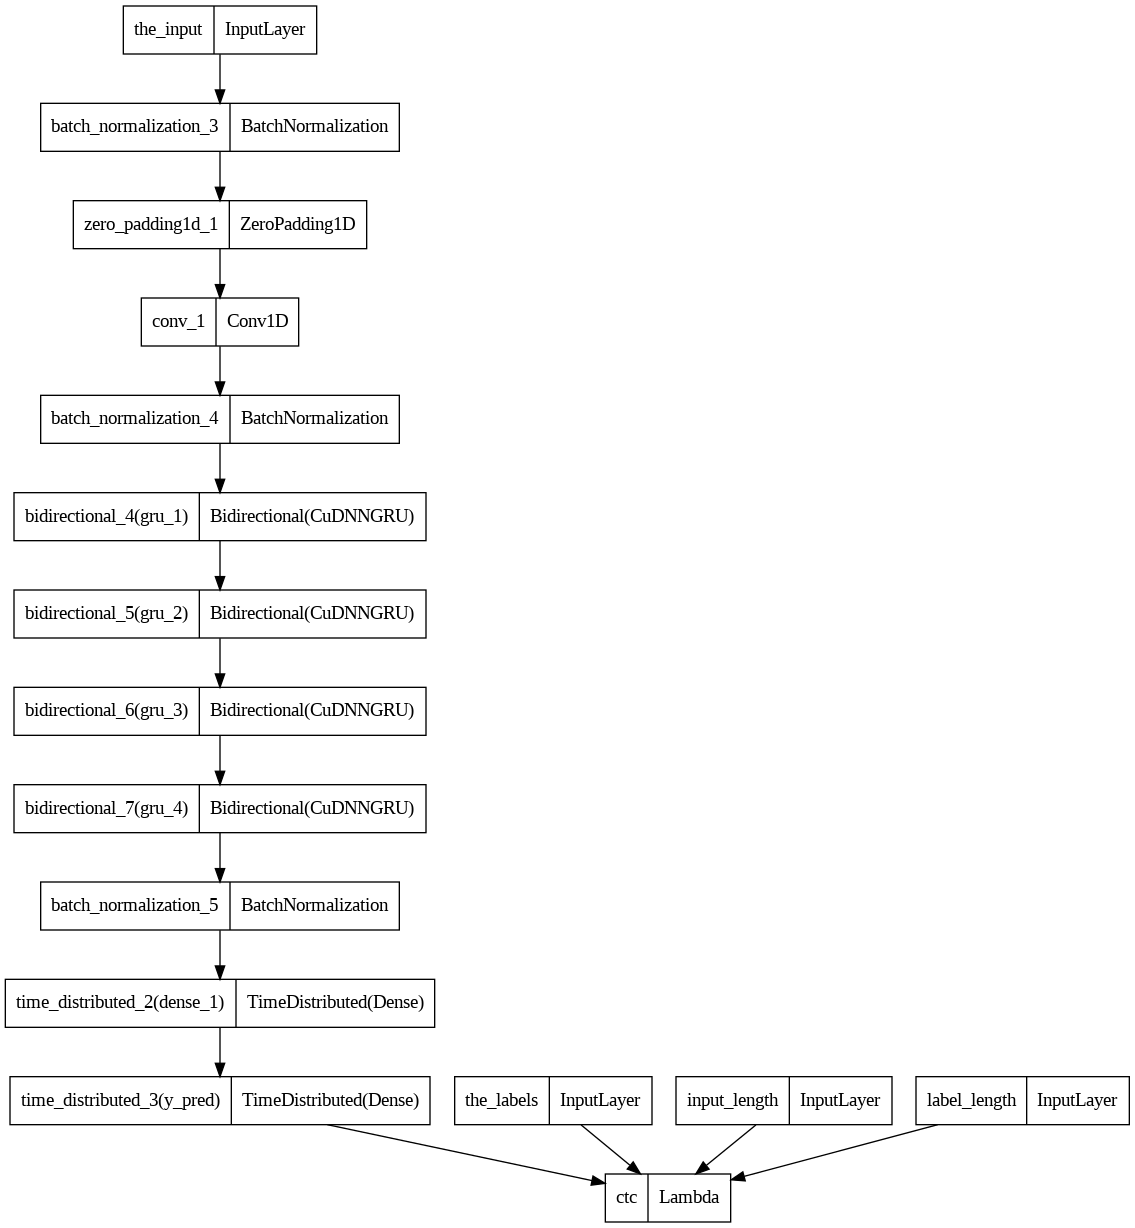

In [82]:
plot_model(model, to_file='deepspeech_model.png', expand_nested=True)

In [83]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 the_input (InputLayer)      [(None, None, 161)]          0         []                            
                                                                                                  
 batch_normalization_3 (Bat  (None, None, 161)            644       ['the_input[0][0]']           
 chNormalization)                                                                                 
                                                                                                  
 zero_padding1d_1 (ZeroPadd  (None, None, 161)            0         ['batch_normalization_3[0][0]'
 ing1D)                                                             ]                             
                                                                                            